In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

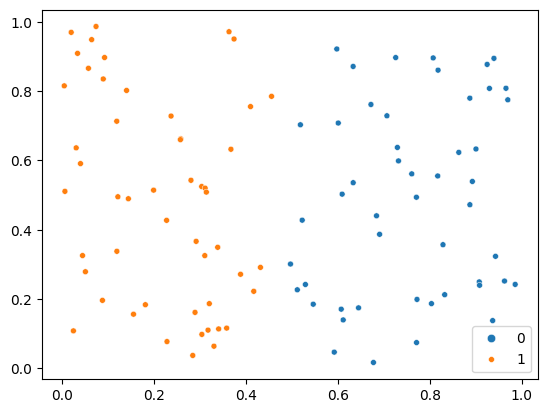

In [2]:
labels_means = []
class KMeans:
    def __init__(self, n_clusters, max_iter=500):
        self.n_clusters = n_clusters
        self.max_iter = max_iter

    def fit(self, X, fully_vectorized=False):
        # Randomly initialize cluster centroids
        self.centroids = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]

        for _ in range(self.max_iter):
            # Assign each data point to the nearest centroid
            labels = self._assign_labels(X)
            
            # Update cluster centroids
            new_centroids = self._update_centroids(X, labels, fully_vectorized)
            
            # Check for convergence
            if np.allclose(new_centroids, self.centroids):
                break
            
            self.centroids = new_centroids

        return self._assign_labels(X)

                
    def _assign_labels(self, X):
        distances = np.sqrt(((X[:, np.newaxis] - self.centroids) ** 2).sum(axis=2))
        # print(distances)
        return np.argmin(distances, axis=1)
    
    def _update_centroids(self, X, labels, fully_vectorized=False):
        new_centroids = np.empty_like(self.centroids)
        
        if not fully_vectorized:
            for i in range(self.n_clusters):
                new_centroids[i] = np.mean(X[labels == i], axis=0)
        else:
            labels = labels[:,None] == np.arange(self.n_clusters)
            labels = labels.astype(int)
            clusters_amounts = np.sum(labels, axis=0)
            a = X[:,:,None] * labels[:,None,:]
            sum1 = np.sum(a, axis=0)
            mean_of_clusters = sum1/clusters_amounts
            new_centroids = mean_of_clusters.T

        return new_centroids
    
# Example usage
np.random.seed(42)
X = np.random.rand(100, 2)
# X = image_original.reshape(-1,3).copy()

kmeans = KMeans(n_clusters=2)
labels = kmeans.fit(X, fully_vectorized=False)

sns.scatterplot(x=X[:,0],y=X[:,1],hue=labels,size=1)
plt.show()

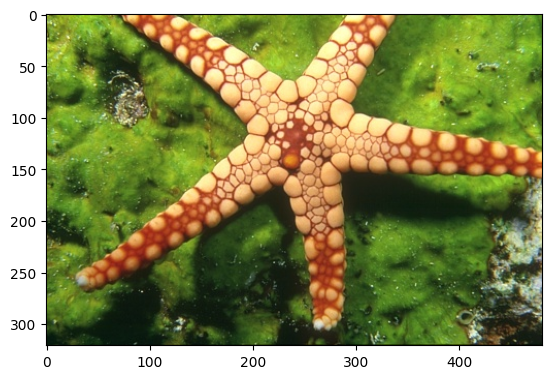

(321, 481, 3)


In [64]:
star_image = cv2.imread("star.jpg")
star_image  = cv2.cvtColor(star_image, cv2.COLOR_BGR2RGB)
plt.imshow(star_image)
plt.show()
print(star_image.shape)

In [65]:
ronto_image = cv2.imread("../4_dimentionality_reduction/ronto_image.jpg")
ronto_image = cv2.cvtColor(ronto_image, cv2.COLOR_BGR2RGB)

In [54]:
def cluster_image(image, num_clusters, clustering_class=KMeans):
    X = image.reshape(-1,3).copy()
    kmeans = clustering_class(n_clusters=num_clusters)
    labels = kmeans.fit(X.astype(np.float32))
    for i in range(num_clusters):
        X[labels==i] = np.array(kmeans.centroids[i]).astype(np.int32)
    return X.reshape(image.shape)

In [46]:
def clustering_with_pixel_position(image, num_clusters, clustering_class=KMeans):
    P = image.copy()
    new_shape = image.shape[:2] + (5,)
    new_P = np.zeros(new_shape) # array with (i,j) for each pixel

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            new_P[i,j] = np.concatenate([P[i,j], np.array([i, j])])

    channel1 = new_P[:,:,3]
    channel2 = new_P[:,:,4]

    # Determine the current min and max values of the additional channels
    old_min1 = np.min(new_P[:,:,3])
    old_max1 = np.max(new_P[:,:,3])
    old_min2 = np.min(new_P[:,:,4])
    old_max2 = np.max(new_P[:,:,4])

    # Map the additional channels to the 0-255 range
    new_min = 0
    new_max = 255

    # Perform linear mapping
    new_channel1 = ((channel1 - old_min1) * (new_max - new_min) / (old_max1 - old_min1)) + new_min
    new_channel2 = ((channel2 - old_min2) * (new_max - new_min) / (old_max2 - old_min2)) + new_min

    # Convert to integers (assuming you want integer values)
    new_P[:,:,3] = new_channel1.astype(int)
    new_P[:,:,4] = new_channel2.astype(int)


    # Need to normalize the channels to distribute the same
        #NORMALIZATION....

    P = new_P.reshape(-1,5).astype(np.float32)
    kmeans =clustering_class(n_clusters=num_clusters)
    labels = kmeans.fit(P)


    for i in range(num_clusters):
        P[labels==i] = np.array(kmeans.centroids[i]).astype(np.int32)

    P = P.reshape(new_shape)
    P = P[:,:,:3].astype(np.int32) # Take only BGR channels
    return P

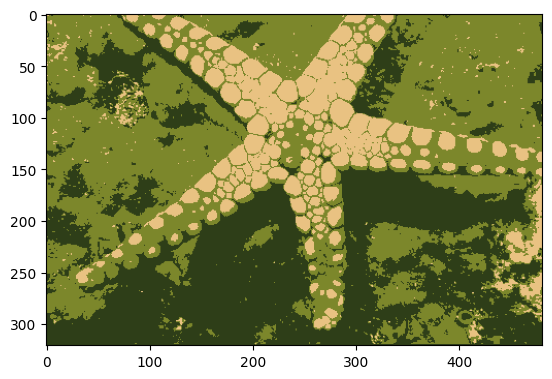

In [69]:
clustered_image = cluster_image(star_image, 3)
plt.imshow(clustered_image)

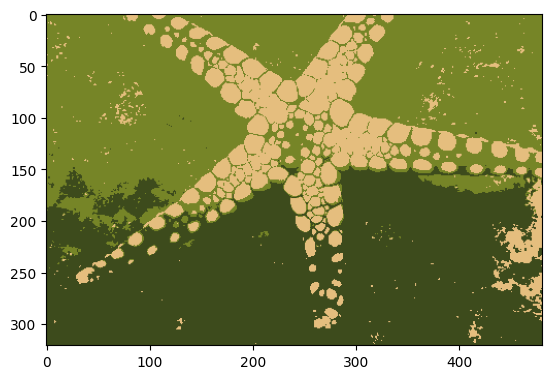

In [70]:
clustered_image = clustering_with_pixel_position(star_image,3)
plt.imshow(clustered_image)

##### As we can see, some places the tentacles are cominbing with the background when using pixel distance as well.

In [72]:
import numpy as np

class AgglomerativeClustering:
    def __init__(self, n_clusters=2, linkage='single'):
        self.n_clusters = n_clusters
        self.linkage = linkage

    def fit(self, X):
        # Initialize clusters as singletons
        clusters = [[i] for i in range(len(X))]

        while len(clusters) < self.n_clusters:
            n = len(clusters)
            distances = self._get_distances(clusters)
            min_index = np.unravel_index(np.argmin(distances), distances.shape)
            i,j = min_index
            # clusters = clusters[:i] + clusters[i]
            
    def _get_distances(self,clusters):
        n = len(clusters)
        distances = np.zeros((n,n))
        for i in range(n):
            for j in range(n):
                distance = self.compute_distance(clusters[i], clusters[j])

        return distances

        


    def compute_distance(self, cluster1, cluster2):
        if self.linkage == 'single':
            return self.single_linkage(cluster1, cluster2)
        elif self.linkage == 'complete':
            return self.complete_linkage(cluster1, cluster2)
        elif self.linkage == 'average':
            return self.average_linkage(cluster1, cluster2)
        else:
            raise ValueError("Linkage type not supported.")

    def single_linkage(self, cluster1, cluster2):
        return np.min(np.linalg.norm(cluster1[:, np.newaxis] - cluster2, axis=2))

    def complete_linkage(self, cluster1, cluster2):
        return np.max(np.linalg.norm(cluster1[:, np.newaxis] - cluster2, axis=2))

    def average_linkage(self, cluster1, cluster2):
        return np.mean(np.linalg.norm(cluster1[:, np.newaxis] - cluster2, axis=2))

# Example usage:
# Generate some random data
np.random.seed(0)
X = np.random.rand(10, 2)

# Initialize and fit AgglomerativeClustering
agg_cluster = AgglomerativeClustering(n_clusters=3)
labels = agg_cluster.fit(X)

print("Cluster labels:", labels)


Cluster labels: None


In [79]:
l = [[1,2],[3,4],[5,6]]
l[:2] + (l[1] + l[2])

[[1, 2], [3, 4], 3, 4, 5, 6]

In [74]:

# Example 2D array
array_2d = np.array([[1, 2, 3],
                     [4, 5, 6],
                     [7, 8, 9]])

# Find the index of the minimum value
min_index = np.unravel_index(np.argmin(array_2d), array_2d.shape)
min_index = np.argmin(array_2d), array_2d.shape

print("Index of the minimum value:", min_index)

Index of the minimum value: (0, (3, 3))


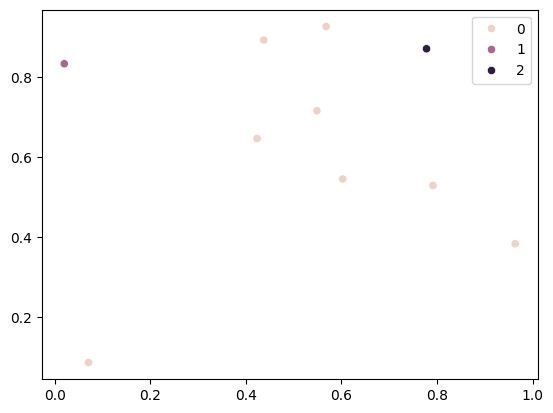

In [232]:
sns.scatterplot(x=X[:,0],y=X[:,1],hue=labels)
plt.show()